Development.ipynb  Tests.ipynb


# Imports

In [1]:
import os
import sys
import random 
import functools

import cv2
import numpy as np
import torch
import torch.nn as nn

import torchvision
import torchvision.transforms as transforms
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt 
import albumentations as albu
import albumentations.pytorch as albu_pt
import piq

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container {width:100% !important;}</style>"))

# Fix to be able to import python modules inside a notebook
os.chdir('..')

# Useful extensions
%load_ext watermark
%watermark -v -n -m -p numpy,torch,albumentations,photosynthesis_metrics

# %load_ext autoreload
# %autoreload 2

# Nice plot formating
%matplotlib inline

Mon Jul 06 2020 

CPython 3.6.9
IPython 7.8.0

numpy 1.17.0
torch 1.6.0.dev20200610
albumentations 0.4.5
photosynthesis_metrics not installed

compiler   : GCC 8.4.0
system     : Linux
release    : 4.15.0-108-generic
machine    : x86_64
processor  : x86_64
CPU cores  : 16
interpreter: 64bit


In [17]:
x = torch.randn(4, 4)
# y = torch.rfft(x, 2, onesided=False)
y = torch.stack([x, torch.zeros_like(x)], dim=-1)
print(x.shape, y.shape)

ifft = torch.ifft(y, 2)[..., 0]
irfft = torch.irfft(y, 2, onesided=False)

print(ifft.shape, irfft.shape)
print(ifft, "\n", irfft)






torch.Size([4, 4]) torch.Size([4, 4, 2])
torch.Size([4, 4]) torch.Size([4, 4])
tensor([[ 0.1275,  0.1148,  0.4154,  0.1148],
        [ 0.5056,  0.0122, -0.0510, -0.1064],
        [-0.2891, -0.1570,  0.0370, -0.1570],
        [ 0.5056, -0.1064, -0.0510,  0.0122]]) 
 tensor([[ 0.3083,  0.0786,  0.3339,  0.0786],
        [ 0.4727, -0.1318, -0.0180,  0.0376],
        [-0.2615, -0.1208, -0.0899, -0.1208],
        [ 0.4727,  0.0376, -0.0180, -0.1318]])


# FSIM and FSIMc

In [152]:
r"""Implemetation of Feature Similarity Index Measure
Code is based on MATLAB version for computations in pixel domain
https://www4.comp.polyu.edu.hk/~cslzhang/IQA/FSIM/Files/FeatureSIM.m
References:
    https://www4.comp.polyu.edu.hk/~cslzhang/IQA/TIP_IQA_FSIM.pdf
"""
import math
import functools
from typing import Union, Tuple

import torch
from torch.nn.modules.loss import _Loss

from piq.utils import _adjust_dimensions, _validate_input
from piq.functional import ifftshift, get_meshgrid, similarity_map, gradient_map, scharr_filter


def fsim(x: torch.Tensor, y: torch.Tensor, reduction: str = 'mean',
         data_range: Union[int, float] = 1.0, chromatic: bool = True,
         scales: int = 4, orientations: int = 4, min_length: int = 6,
         mult: int = 2, sigma_f: float = 0.55, delta_theta: float = 1.2,
         k: float = 2.0) -> torch.Tensor:
    r"""Compute Feature Similarity Index Measure for a batch of images.
    

    Args:
        x: Batch of predicted images with shape (batch_size x channels x H x W)
        y: Batch of target images with shape  (batch_size x channels x H x W)
        data_range: Value range of input images (usually 1.0 or 255). Default: 1.0
        chromatic: Flag to compute FSIMc, which also takes into account chromatic components
        scales: Number of wavelets used for computation of phase congruensy maps
        orientations: Number of filter orientations used for computation of phase congruensy maps
        min_length: Wavelength of smallest scale filter
        mult: Scaling factor between successive filters
        sigma_f: Ratio of the standard deviation of the Gaussian describing the log Gabor filter's
            transfer function in the frequency domain to the filter center frequency.
        delta_theta: Ratio of angular interval between filter orientations and the standard deviation
            of the angular Gaussian function used to construct filters in the frequency plane.
        k: No of standard deviations of the noise energy beyond the mean at which we set the noise
            threshold  point, below which phase congruency values get penalized.
        
    Returns:
        FSIM: Index of similarity betwen two images. Usually in [0, 1] interval.
            Can be bigger than 1 for predicted images with higher contrast than original one.
    Note:
        This implementation is based on original authors MATLAB code.
        https://www4.comp.polyu.edu.hk/~cslzhang/IQA/FSIM/FSIM.htm
        
    """
    
    _validate_input(input_tensors=(x, y), allow_5d=False)
    x, y = _adjust_dimensions(input_tensors=(x, y))
    
    # Scale to [0., 1.] range
    x = x / float(data_range)
    y = y / float(data_range)
    
    # Rescale to [0, 255] range, because all constant are calculated for this factor
    x = x * 255
    y = y * 255
    
    # Apply average pooling
    kernel_size = max(1, round(min(x.shape[-2:]) / 256))
    x = torch.nn.functional.avg_pool2d(x, kernel_size, stride=2)
    y = torch.nn.functional.avg_pool2d(y, kernel_size, stride=2)
        
    num_channels = x.size(1)

    # Convert RGB to YIQ color space https://en.wikipedia.org/wiki/YIQ
    if num_channels == 3:
        yiq_weights = torch.tensor([
            [0.299, 0.587, 0.114],
            [0.5959, -0.2746, -0.3213],
            [0.2115, -0.5227, 0.3112]]).t().to(x)
        x = torch.matmul(x.permute(0, 2, 3, 1), yiq_weights).permute(0, 3, 1, 2)
        y = torch.matmul(y.permute(0, 2, 3, 1), yiq_weights).permute(0, 3, 1, 2)
        
        x_lum = x[:, : 1, :, :]
        y_lum = y[:, : 1, :, :]
        
        x_i = x[:, 1, :, :]
        y_i = y[:, 1, :, :]
        x_q = x[:, 2, :, :]
        y_q = y[:, 2, :, :]

    else:
        x_lum = x
        y_lum = y

    # Compute phase congruency maps
    pc_x = _phase_congruency(
        x_lum, scales=scales, orientations=orientations,
        min_length=min_length, mult=mult, sigma_f=sigma_f,
        delta_theta=delta_theta, k=k
    )
    pc_y = _phase_congruency(
        y_lum, scales=scales, orientations=orientations,
        min_length=min_length, mult=mult, sigma_f=sigma_f,
        delta_theta=delta_theta, k=k
    )
    
    # Gradient maps
    kernels = torch.stack([scharr_filter(), scharr_filter().transpose(-1, -2)])
    grad_map_x = gradient_map(x_lum, kernels)
    grad_map_y = gradient_map(y_lum, kernels)
    
    # Constants from paper
    T1, T2, T3, T4, lmbda = 0.85, 160, 200, 200, 0.03
    
    # Compute FSIM
    PC = similarity_map(pc_x, pc_y, T1)
    GM = similarity_map(grad_map_x, grad_map_y, T2)
    pc_max = torch.where(pc_x > pc_y, pc_x, pc_y)
    score = GM * PC * pc_max
    
    if chromatic:
        S_I = similarity_map(x_i, y_i, T3)
        S_Q = similarity_map(x_q, y_q, T4)
        score = score * torch.abs(S_I * S_Q) ** lmbda
        # Complex gradients will work in PyTorch 1.6.0
        # score = score * torch.real((S_I * S_Q).to(torch.complex64) ** lmbda)

    result = score.sum(dim=[1, 2, 3]) / pc_max.sum(dim=[1, 2, 3])
    
    if reduction == 'none':
        return result

    return {'mean': result.mean,
            'sum': result.sum
            }[reduction](dim=0)


def _construct_filters(x: torch.Tensor, scales: int = 4, orientations: int = 4,
                       min_length: int = 6, mult: int = 2, sigma_f: float = 0.55,
                       delta_theta: float = 1.2, k: float = 2.0):
    """Creates stack of filters used for computation of phase congruensy maps
    
    Args:
        x: Tensor with shape Bx1xHxW
        scales: Number of wavelets
        orientations: Number of filter orientations
        min_length: Wavelength of smallest scale filter
        mult: Scaling factor between successive filters
        sigma_f: Ratio of the standard deviation of the Gaussian
            describing the log Gabor filter's transfer function
            in the frequency domain to the filter center frequency.
        delta_theta: Ratio of angular interval between filter orientations
            and the standard deviation of the angular Gaussian function
            used to construct filters in the freq. plane.
        k: No of standard deviations of the noise energy beyond the mean
            at which we set the noise threshold point, below which phase
            congruency values get penalized.
        """
    B, _, H, W = x.shape

    # Calculate the standard deviation of the angular Gaussian function
    # used to construct filters in the freq. plane.
    theta_sigma = math.pi / (orientations * delta_theta)

    # Pre-compute some stuff to speed up filter construction
    grid_x, grid_y = get_meshgrid((H, W))
    radius = torch.sqrt(grid_x ** 2 + grid_y ** 2)
    theta = torch.atan2(-grid_y, grid_x)

    # Quadrant shift radius and theta so that filters are constructed with 0 frequency at the corners.
    # Get rid of the 0 radius value at the 0 frequency point (now at top-left corner)
    # so that taking the log of the radius will not cause trouble.
    radius = ifftshift(radius)
    theta = ifftshift(theta)
    radius[0, 0] = 1

    sintheta = torch.sin(theta)
    costheta = torch.cos(theta)

    # Filters are constructed in terms of two components.
    # 1) The radial component, which controls the frequency band that the filter responds to
    # 2) The angular component, which controls the orientation that the filter responds to.
    # The two components are multiplied together to construct the overall filter.

    # First construct a low-pass filter that is as large as possible, yet falls
    # away to zero at the boundaries.  All log Gabor filters are multiplied by
    # this to ensure no extra frequencies at the 'corners' of the FFT are
    # incorporated as this seems to upset the normalisation process when
    lp = _lowpassfilter(size=(H, W), cutoff=.45, n=15)

    # Construct the radial filter components...
    log_gabor = []
    for s in range(scales):
        wavelength = min_length * mult ** s
        fo = 1.0 / wavelength  # Centre frequency of filter.
        gabor_filter = torch.exp((- torch.log(radius / fo) ** 2) / (2 * math.log(sigma_f) ** 2))
        gabor_filter = gabor_filter * lp
        gabor_filter[0, 0] = 0
        log_gabor.append(gabor_filter)

    # Then construct the angular filter components...
    spread = []
    for o in range(orientations):
        angl = o * math.pi / orientations

        # For each point in the filter matrix calculate the angular distance from
        # the specified filter orientation.  To overcome the angular wrap-around
        # problem sine difference and cosine difference values are first computed
        # and then the atan2 function is used to determine angular distance.
        ds = sintheta * math.cos(angl) - costheta * math.sin(angl)  # Difference in sine.
        dc = costheta * math.cos(angl) + sintheta * math.sin(angl)  # Difference in cosine.
        dtheta = torch.abs(torch.atan2(ds, dc))
        spread.append(torch.exp((- dtheta ** 2) / (2 * theta_sigma ** 2)))

    spread = torch.stack(spread)
    log_gabor = torch.stack(log_gabor)
    
    # Multiply, add batch dimension and transfer to correct device.
    filters = (spread.repeat_interleave(scales, dim=0) * log_gabor.repeat(orientations, 1, 1)).unsqueeze(0).to(x)
    return filters


def _phase_congruency(x: torch.Tensor, scales: int = 4, orientations: int = 4,
                      min_length: int = 6, mult: int = 2, sigma_f: float = 0.55,
                      delta_theta: float = 1.2, k: float = 2.0) -> torch.Tensor:
    r"""Compute Phase Congruence for a batch of greyscale images

    Args:
        x: Tensor with shape Bx1xHxW
        levels: Number of wavelet scales
        orientations: Number of filter orientations
        min_length: Wavelength of smallest scale filter
        mult: Scaling factor between successive filters
        sigma_f: Ratio of the standard deviation of the Gaussian
            describing the log Gabor filter's transfer function
            in the frequency domain to the filter center frequency.
        delta_theta: Ratio of angular interval between filter orientations
            and the standard deviation of the angular Gaussian function
            used to construct filters in the freq. plane.
        k: No of standard deviations of the noise energy beyond the mean
            at which we set the noise threshold point, below which phase
            congruency values get penalized.
    Returns:
        PCmap: Tensor with shape BxHxW

    """
    EPS = 1e-4

    B, _, H, W = x.shape

    # Fourier transform
    imagefft = torch.rfft(x, 2, onesided=False)

    filters = _construct_filters(x, scales, orientations, min_length, mult, sigma_f, delta_theta, k)

    # Note rescaling to match power record ifft2 of filter
    filters_ifft = torch.ifft(torch.stack([filters, torch.zeros_like(filters)], dim=-1), 2)[..., 0] * math.sqrt(H * W)
    
    # Convolve image with even and odd filters
    E0 = torch.ifft(imagefft * filters.unsqueeze(-1), 2).view(B, orientations, scales, H, W, 2)

    # Amplitude of even & odd filter response. An = sqrt(real^2 + imag^2)
    an = torch.sqrt(torch.sum(E0 ** 2, dim=-1))

    # Take filter at scale 0 and sum spatially
    # Record mean squared filter value at smallest scale.
    # This is used for noise estimation.
    em_n = (filters.view(1, orientations, scales, H, W)[:, :, :1, ...] ** 2).sum(dim=[-2, -1], keepdims=True)

    # Sum of even filter convolution results.
    sum_e = E0[..., 0].sum(dim=2, keepdims=True)
    
    # Sum of odd filter convolution results.
    sum_o = E0[..., 1].sum(dim=2, keepdims=True)
    
    # Get weighted mean filter response vector, this gives the weighted mean phase angle.
    x_energy = torch.sqrt(sum_e ** 2 + sum_o ** 2) + EPS

    mean_e = sum_e / x_energy
    mean_o = sum_o / x_energy

    # Now calculate An(cos(phase_deviation) - | sin(phase_deviation)) | by
    # using dot and cross products between the weighted mean filter response
    # vector and the individual filter response vectors at each scale.
    # This quantity is phase congruency multiplied by An, which we call energy.

    # Extract even and odd convolution results.
    E = E0[..., 0]
    O = E0[..., 1]

    energy = (E * mean_e + O * mean_o - torch.abs(E * mean_o - O * mean_e)).sum(dim=2, keepdim=True)
    
    # Compensate for noise
    # We estimate the noise power from the energy squared response at the
    # smallest scale.  If the noise is Gaussian the energy squared will have a
    # Chi-squared 2DOF pdf.  We calculate the median energy squared response
    # as this is a robust statistic.  From this we estimate the mean.
    # The estimate of noise power is obtained by dividing the mean squared
    # energy value by the mean squared filter value
    
    abs_e0 = torch.sqrt(torch.sum(E0[:, :, :1, ...] ** 2, dim=-1)).reshape(B, orientations, 1, 1, H * W)
    median_e2n = torch.median(abs_e0 ** 2, dim=-1, keepdims=True).values

    mean_e2n = - median_e2n / math.log(0.5)

    # Estimate of noise power.
    noisePower = mean_e2n / em_n
    
    # Now estimate the total energy^2 due to noise
    # Estimate for sum(An^2) + sum(Ai.*Aj.*(cphi.*cphj + sphi.*sphj))
    filters_ifft = filters_ifft.view(1, orientations, scales, H, W)
    
    sum_an2 = torch.sum(filters_ifft ** 2, dim=-3, keepdim=True)
    
    sum_ai_aj = torch.zeros(B, orientations, 1, H, W).to(x)
    for s in range(scales - 1):
        sum_ai_aj = sum_ai_aj + (filters_ifft[:, :, s: s + 1] * filters_ifft[:, :, s + 1:]).sum(dim=-3, keepdim=True)
            
    sum_an2 = torch.sum(sum_an2, dim=[-1, -2], keepdim=True)
    sum_ai_aj = torch.sum(sum_ai_aj, dim=[-1, -2], keepdim=True)

    noise_energy2 = 2 * noisePower * sum_an2 + 4 * noisePower * sum_ai_aj

    # Rayleigh parameter
    tau = torch.sqrt(noise_energy2 / 2)

    # Expected value of noise energy
    noise_energy = tau * math.sqrt(math.pi / 2)
    moise_energy_sigma = torch.sqrt((2 - math.pi / 2) * tau ** 2)

    # Noise threshold
    T = noise_energy + k * moise_energy_sigma

    # The estimated noise effect calculated above is only valid for the PC_1 measure.
    # The PC_2 measure does not lend itself readily to the same analysis.  However
    # empirically it seems that the noise effect is overestimated roughly by a factor
    # of 1.7 for the filter parameters used here.

    # Empirical rescaling of the estimated noise effect to suit the PC_2 phase congruency measure
    T = T / 1.7

    # Apply noise threshold
    energy = torch.max(energy - T, torch.zeros_like(T))

    eps = torch.finfo(energy.dtype).eps
    energy_all = energy.sum(dim=[1, 2]) + eps
    an_all = an.sum(dim=[1, 2]) + eps
    result_pc = energy_all / an_all
    return result_pc.unsqueeze(1)


def _lowpassfilter(size: Union[int, Tuple[int, int]], cutoff: float, n: int) -> torch.Tensor:
    r"""
    Constructs a low-pass Butterworth filter.
    Args:
        size: Tuple with heigth and width of filter to construct
        cutoff: Cutoff frequency of the filter in (0, 0.5()
        n: Filter order. Higher `n` means sharper transition.
            Note that `n` is doubled so that it is always an even integer.
        
    Returns:
        f = 1 / (1 + w/cutoff) ^ 2n
    
    Note:
        The frequency origin of the returned filter is at the corners.
    
    """

    assert (cutoff >= 0) and (cutoff <= 0.5), "Cutoff frequency must be between 0 and 0.5"
    assert n > 1, "n must be an integer >= 1"

    grid_x, grid_y = get_meshgrid(size)
    
    # A matrix with every pixel = radius relative to centre.
    radius = torch.sqrt(grid_x ** 2 + grid_y ** 2)

    return ifftshift(1. / (1.0 + (radius / cutoff) ** (2 * n)))


class FSIMLoss(_Loss):
    r"""Creates a criterion that measures the FSIM or FSIMc for input :math:`x` and target :math:`y`.

    In order to be considered as a loss, value `1 - clip(FSIM, min=0, max=1)` is returned. If you need FSIM value,
    use function `fsim` instead.

    Args:
        chromatic: Flag to compute FSIMc, which also takes into account chromatic components
        reduction: Specifies the reduction to apply to the output:
            ``'none'`` | ``'mean'`` | ``'sum'``. ``'none'``: no reduction will be applied,
            ``'mean'``: the sum of the output will be divided by the number of
            elements in the output, ``'sum'``: the output will be summed. Note: :attr:`size_average`
            and :attr:`reduce` are in the process of being deprecated, and in the meantime,
            specifying either of those two args will override :attr:`reduction`. Default: ``'mean'``
        data_range: The difference between the maximum and minimum of the pixel value,
            i.e., if for image x it holds min(x) = 0 and max(x) = 1, then data_range = 1.
            The pixel value interval of both input and output should remain the same.
        scales: Number of wavelets used for computation of phase congruensy maps
        orientations: Number of filter orientations used for computation of phase congruensy maps
        min_length: Wavelength of smallest scale filter
        mult: Scaling factor between successive filters
        sigma_f: Ratio of the standard deviation of the Gaussian describing the log Gabor filter's
            transfer function in the frequency domain to the filter center frequency.
        delta_theta: Ratio of angular interval between filter orientations and the standard deviation
            of the angular Gaussian function used to construct filters in the frequency plane.
        k: No of standard deviations of the noise energy beyond the mean at which we set the noise
            threshold  point, below which phase congruency values get penalized.

    Shape:
        - Input: Required to be 2D (H, W), 3D (C,H,W), 4D (N,C,H,W) or 5D (N,C,H,W,2), channels first.
        - Target: Required to be 2D (H, W), 3D (C,H,W), 4D (N,C,H,W) or 5D (N,C,H,W,2), channels first.

    Examples::

        >>> loss = FSIMLoss()
        >>> prediction = torch.rand(3, 3, 256, 256, requires_grad=True)
        >>> target = torch.rand(3, 3, 256, 256)
        >>> output = loss(prediction, target)
        >>> output.backward()

    References:
        .. [1] Anish Mittal et al. "No-Reference Image Quality Assessment in the Spatial Domain",
        https://live.ece.utexas.edu/publications/2012/TIP%20BRISQUE.pdf
        """
    def __init__(self, data_range: Union[int, float] = 1., reduction: str = 'mean', scales: int = 4,
                 orientations: int = 4, min_length: int = 6, mult: int = 2, sigma_f: float = 0.55,
                 delta_theta: float = 1.2, k: float = 2.0) -> None:

        super().__init__()
        self.data_range = data_range
        self.reduction = reduction

        # Save function with predefined parameters, rather than parameters themself
        self.fsim = functools.partial(
            fsim,
            data_range=data_range,
            reduction=reduction,
            scales=scales,
            orientations=orientations,
            min_length=min_length,
            mult=mult,
            sigma_f=sigma_f,
            delta_theta=delta_theta,
            k=k,
        )

    def forward(self, prediction: torch.Tensor, target: torch.Tensor) -> torch.Tensor:
        r"""Computation of FSIM as a loss function.
        Args:
            prediction: Tensor of prediction of the network.
            target: Reference tensor.
        Returns:
            Value of FSIM loss to be minimized. 0 <= FSIM <= 1.
        """
        # All checks are done inside fsim function
        score = self.fsim(prediction, target)

        # Make sure value to be in [0, 1] range and convert to loss
        return 1 - torch.clamp(score, 0, 1)


In [153]:
# x = torch.zeros(4, 3, 128, 128)
# y = torch.zeros(4, 3, 128, 128)
x = torch.rand(4, 3, 128, 128)
y = torch.rand(4, 3, 128, 128)

# x = torch.ones(4, 3, 128, 128)
# y = torch.ones(4, 3, 128, 128)
print(fsim(x, y, reduction='none', chromatic=False))

# print(fsim_bad(x, y, reduction='none', chromatic=False))

tensor([0.7759, 0.7812, 0.7768, 0.7776])


In [25]:
# goldhill <-> goldhill_jpeg
FSIM =  0.89691
FSIMc =  0.89691
VSI

# goldhill <-> goldhill_blur
FSIM =  0.91063
FSIMc =  0.91063


# I01 <-> i01_01_5
FSIM =  0.93674
FSIMc =  0.92587
VSI =  0.96405





NameError: name 'VSI' is not defined

In [24]:
# Read images
import cv2
from skimage.io import imread

I01 = torch.tensor(imread('data/external/I01.BMP')).permute(2, 0, 1)
i1_01_5 = torch.tensor(imread('data/external/i01_01_5.bmp')).permute(2, 0, 1)

goldhill = torch.tensor(imread('data/external/goldhill.gif'))
goldhill_jpeg = torch.tensor(imread('data/external/goldhill_jpeg.gif'))



print("i1_01_5 FSIM", fsim(i1_01_5, I01, data_range=255, chromatic=False))
print("i1_01_5 FSIMc", fsim(i1_01_5, I01, data_range=255, chromatic=True))

print("goldhill_jpeg FSIM", fsim(goldhill_jpeg, goldhill, data_range=255, chromatic=False))

# fsim = 
# ------------------
# image1 = mpimg.imread('data/external/I01.BMP')
# image2 = mpimg.imread('data/external/i01_01_5.bmp')

# Convert to tensor and create fake batch
# image1_t_cuda = torch.tensor(image1).permute(2, 0, 1).unsqueeze(0).cuda() / 255.
# image2_t_cuda = torch.tensor(image2).permute(2, 0, 1).unsqueeze(0).cuda() / 255.
# image2_t_cuda = torch.tensor(image3).permute(2, 0, 1).unsqueeze(0).cuda()
# print("Input image shape:", image1_t_cuda.shape)

# image1_t_cuda.requires_grad_()
# loss = fsim(image1_t_cuda, image2_t_cuda, reduction='none', data_range=1, chromatic=True)
# loss.backward()

# image1_t_cuda = torch.tensor(image1).unsqueeze(0).unsqueeze(0).repeat(3, 1, 1, 1).cuda() / 255.
# image2_t_cuda = torch.tensor(image2).unsqueeze(0).unsqueeze(0).repeat(3, 1, 1, 1).cuda() / 255.

# image1_t_cuda = torch.tensor(image1).unsqueeze(0).unsqueeze(0).cuda() / 255.
# image2_t_cuda = torch.tensor(image2).unsqueeze(0).unsqueeze(0).cuda() / 255.

# fsim(image1_t_cuda, image2_t_cuda, reduction='none', data_range=1.0, chromatic=False)
# image1_t_cuda = torch.tensor(image1).unsqueeze(0).unsqueeze(0).cuda() / 255.
# image2_t_cuda = torch.tensor(image2).unsqueeze(0).unsqueeze(0).cuda() / 255.

# image1_t_cuda = torch.rand(3, 3, 8, 8)
# image2_t_cuda = torch.rand(3, 3, 8, 8)
# fsim(image1_t_cuda, image2_t_cuda, reduction='none', data_range=1.0, chromatic=True)





i1_01_5 FSIM tensor(0.9367)
i1_01_5 FSIMc tensor(0.9259)
goldhill_jpeg FSIM tensor(0.8969)


# VSI

In [62]:
from piq import fsim, psnr

In [114]:
# x = torch.zeros(4, 3, 128, 128)
# y = torch.zeros(4, 3, 128, 128)
x = torch.rand(4, 3, 128, 128)
y = torch.rand(4, 3, 128, 128)

# x = torch.ones(4, 3, 128, 128)
# y = torch.ones(4, 3, 128, 128)
fsim(x, y, reduction='none')

tensor([3.1123, 2.9341, 2.9150, 3.0244])

In [57]:
# Test different Log Gabor filters

size = (1024, 512)
def get_meshgrid(size: Tuple[int, int]) -> torch.Tensor:
    """
    Args:
        size: Shape of meshgrid to create
    """
    if size[0] % 2:
        # Odd
        x = torch.range(-(size[0] - 1) / 2, (size[0] - 1) / 2) / (size[0] - 1)
    else:
        # Even
        x = torch.range(- size[0] / 2, size[0] / 2 - 1) / size[0]
    
    if size[1] % 2:
        # Odd
        y = torch.range(-(size[1] - 1) / 2, (size[1] - 1) / 2) / (size[1] - 1)
    else:
        # Even
        y = torch.range(- size[1] / 2, size[1] / 2 - 1) / size[1]
    return torch.meshgrid(x, y)

# # lp = _lowpassfilter(size=(H, W), cutoff=.45, n=15)
# sigma_y = sigma/gamma
# g0 = torch.exp(-0.5 * ((x1**2 / sigma**2) + (y1**2 / sigma_y**2)))
        
        
def log_gabor_filter(size: Tuple[int, int], omega_0: float, sigma_f: float) -> torch.Tensor:
    """Constructs log Gabor filter of given shape. 
    """
    grid_x, grid_y = get_meshgrid(size)
    
    radius = torch.sqrt(grid_x ** 2 + grid_y ** 2)
    radius = ifftshift(radius)
    radius[0, 0] = 1
    
    gabor_filter = torch.exp((- torch.log(radius / omega_0) ** 2) / (2 * math.log(sigma_f) ** 2))
    return gabor_filter


def log_gabor_filter2(size: Tuple[int, int], omega_0: float = 0.021, sigma_f: float = 1.34) -> torch.Tensor:
    
    xx, yy = get_meshgrid(size)

    mask = xx.pow(2) + yy.pow(2) <= 0.25
    xx = xx * mask
    yy = yy * mask

    xx = ifftshift(xx)
    yy = ifftshift(yy)

    r = (xx.pow(2) + yy.pow(2)).sqrt()
    r[0, 0] = 1
    
    lg = torch.exp((- torch.log(r / omega_0) ** 2) / (2 * math.log(sigma_f) ** 2))

    lg[0, 0] = 0
    return lg

# lg = log_gabor_filter(size, omega_0=0.021, sigma_f=1.34)

xx, yy = get_meshgrid(size)
mask = xx.pow(2) + yy.pow(2) <= 0.25

# lg = lg # * mask

# lg2 = log_gabor_filter2(size, omega_0=0.021, sigma_f=1.34)

# torch.sum(lg - lg2)

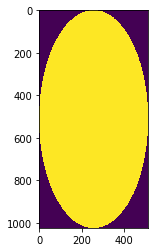

In [58]:
plt.imshow(mask)

In [30]:
print("i1_01_5 VSI", vsi(I01, i1_01_5, data_range=255))

i1_01_5 VSI tensor(0.9521)


# Download datasets

In [ ]:
# mnist = torchvision.datasets.MNIST("../datasets", train=True, download=True)
# cifar10 = torchvision.datasets.CIFAR10("../datasets", download=True)
# cifar100 = torchvision.datasets.CIFAR100("../datasets", download=True)
# fashin_mnist = torchvision.datasets.FashionMNIST("datasets", download=True)

In [ ]:
# !wget -P data/raw http://cs231n.stanford.edu/tiny-imagenet-200.zip
# !wget -P data/raw http://vllab.ucmerced.edu/wlai24/LapSRN/results/SR_testing_datasets.zip
# !wget -P data/raw http://www.cs.columbia.edu/CAVE/databases/SLAM_coil-20_coil-100/coil-100/coil-100.zip
# !wget -P data/raw http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_valid_LR_bicubic_X2.zip
# !wget -P data/raw http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_LR_bicubic_X2.zip
# !wget -P data/raw http://www.ponomarenko.info/tid2013/tid2013.rar

In [1]:
# !wget -P data/raw http://datasets.vqa.mmsp-kn.de/archives/koniq10k_512x384.zip

--2020-06-25 14:49:33--  http://datasets.vqa.mmsp-kn.de/archives/koniq10k_512x384.zip
Resolving datasets.vqa.mmsp-kn.de (datasets.vqa.mmsp-kn.de)... 134.34.224.175
Connecting to datasets.vqa.mmsp-kn.de (datasets.vqa.mmsp-kn.de)|134.34.224.175|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://datasets.vqa.mmsp-kn.de/archives/koniq10k_512x384.zip [following]
--2020-06-25 14:49:33--  https://datasets.vqa.mmsp-kn.de/archives/koniq10k_512x384.zip
Connecting to datasets.vqa.mmsp-kn.de (datasets.vqa.mmsp-kn.de)|134.34.224.175|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 766965996 (731M) [application/zip]
Saving to: ‘datasets/koniq10k_512x384.zip’

koniq10k_512x384.zi 100%[===================>] 731.44M  54.4MB/s    in 14s     

2020-06-25 14:49:48 (53.3 MB/s) - ‘datasets/koniq10k_512x384.zip’ saved [766965996/766965996]



In [2]:
ls

datasets/  Development.ipynb  Tests.ipynb


# Test datasets

## TID2013

In [11]:
from src.data.datasets import TID2013

transform = albu.Compose([
#     albu.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]), # to [-1, 1]
    albu.Normalize(mean=[0., 0., 0.], std=[1., 1., 1.]), # to [0, 1]
    albu_pt.ToTensorV2(),
])

dataset = TID2013(transform=transform)
distorted_images, reference_images, scores = dataset[0]

NameError: name 'albu_pt' is not defined

In [8]:
from src.augmentations import get_aug
from src.utils import walk_files
from src.datasets import *
from torch.utils.data import Dataset

In [9]:
TASK = "denoise"
SIZE = 256

dataset_class = {
    "mnist": MNIST,
    "fashion_mnist": FashionMNIST, 
    "cifar10": CIFAR10,
    "cifar100": CIFAR100,
    "tinyimagenet": TinyImageNet,
    "div2k": DIV2K,
    "set5": Set5,
    "set14": Set14,
    "urba100": Urban100,
    "manga109": Manga109,
    "coil100": COIL100,
    "bsds100": BSDS100,
    "medicaldecathlon": MedicalDecathlon
}


dataset_names = [
    "div2k",
    "bsds100",
#     "set5"
]

datasets = []
for dataset_name in dataset_names:
    transform = get_aug(aug_type="medium", task=TASK, dataset=datasets, size=SIZE)
    datasets.append(dataset_class[dataset_name](train=True, transform=transform))
    

TypeError: unhashable type: 'list'

In [ ]:
for dataset in datasets:
    print(dataset)
    input, target = dataset[1]
    print("Input", input.shape, input.min(), input.max(), input.mean())
    print("Target", target.shape, target.min(), target.max(), target.mean())
    plt.figure(figsize=(10, 15))
    plt.imshow(torch.cat([input, target], dim=2).permute(1, 2, 0) * 0.5 + 0.5, )
    plt.show()
    

In [ ]:
# total_mean, total_var = [], []
# for i in range(len(div2k)):
#     image = div2k[i][1]
#     total_mean.append(image.mean(dim=[1,2]))
#     total_var.append(image.var(dim=[1,2]))
# print(torch.stack(total_mean).mean(dim=0))
# print(torch.stack(total_var).mean(dim=0))



In [ ]:
# Get dataset with no transform
# AUG = get_aug(aug_type='light', dataset="medicaldecathlon", task="denoise", size=256)

# medicaldecathlon = MedicalDecathlon(train=False, transform=AUG)
# image = medicaldecathlon[135][0]
# image.dtype

In [ ]:
# Get dataset with no transform
# AUG = get_aug(aug_type='light', dataset="medicaldecathlon", task="deblur", size=256)

# medicaldecathlon = MedicalDecathlon(train=False, transform=AUG)
# image = medicaldecathlon[135][0]
# image.dtype

In [ ]:
print(image.min(), image.max(), image.mean())

In [ ]:
# idx = 356
print(image[..., 0].min(), image[..., 0].max(), image[...,0].mean())
# plt.hist()
# print(image.min(), image.max(), image.mean())
# grey_image = image[..., 0]
augmented = AUG(image=image, mask=image)
input, target = augmented["image"], augmented["mask"]

## Get gaussian
# random_state = np.random.RandomState(random.randint(0, 2 ** 32 - 1))
# gauss = random_state.normal(0, 0.1, input.shape)
# input = input + gauss
# gauss

# print("Input", input.shape, input.min(), input.max())
# print("Target", target.shape, target.min(), target.max())

# augmented = NORM_TO_TENSOR(image=input, mask=target)
# input, target = augmented["image"], augmented["mask"]

print("Input", input.shape, input.min(), input.max())
print("Target", target.shape, target.min(), target.max())
plt.figure(figsize=(10, 10))
plt.imshow(torch.cat([input[0], target[0]], dim=1)) #.permute(1, 2, 0))
# plt.imshow(torch.cat([input, target], dim=2).permute(1, 2, 0))

torch.sum(input - target)

In [ ]:
torch.mean(input - target)

In [ ]:
plt.imshow((medicaldecathlon[idx][0][..., 0]))

In [ ]:
a = np.random.rand(256, 256)
a = a[:,:,np.newaxis].repeat(3, axis=2)
# a.repeat(3, axis=0).shape

In [ ]:
plt.imshow(torch.cat([input, target], dim=2).permute(1, 2, 0)[:, :, [2, 1, 0]])

## Test dataloaders

In [ ]:
from src.datasets import get_dataloader

In [ ]:
datasets = ["div2k", "bsds100", "set5"]
transform = get_aug(aug_type="val", task="deblur", size=128)

for dataset in datasets:
#     train_loader = get_dataloader(dataset, transform, train=True, batch_size=64)
    
#     for batch in train_loader:
#         input, output = batch
#         print(input.shape, output.shape)
        
    
    val_loader = get_dataloader(dataset, transform, train=False)
    for batch in val_loader:
        input, output = batch
        print(input.shape, output.shape)
    
    
    for batch in train_loader:
        break

In [ ]:
dataset = BSDS100("datasets/BSDS100", train=True, transform=transform)
dataset[0][0].size()

In [ ]:
import photosynthesis_metrics as pm
image_metrics = ["kid", {}, "ssim", {}, ]

METRIC_FROM_NAME = {
    "ssim" : pm.SSIMLoss,
    "ms-ssim" : pm.MultiScaleSSIMLoss,
    "msid" : pm.MSID,
    "fid" : pm.FID,
    "kid" : pm.KID,
#     "content" : ContentLoss,
#     "style" : StyleLoss,
    "tv" : pm.TVLoss,
}


# for metric in image_metrics:
image_metrics = [METRIC_FROM_NAME[metric](**kwargs) for metric, kwargs in zip(image_metrics[::2], image_metrics[1::2])]
# list(zip(image_metrics[::2], image_metrics[1::2]))
image_metrics

In [ ]:
from collections import OrderedDict
output = OrderedDict({
    'loss': 1,
#     'mse': mse,
#     'psnr': psnr,
#     'ssim': ssim_score,
#     # 'val_ms_ssim': ms_ssim_score,
#     'input_features': input_features,
#     'target_features': target_features
})
output["test"] = 3
output["foo"] = "bar"

In [ ]:
images = torch.rand((512, 2, 32, 32))
target = torch.rand((512, 2, 64, 64))
print(f"Before interpolation: images {images.shape}")
images = F.interpolate(images, size=target.shape[-2:], mode="bilinear")
print(f"After interpolation: images {images.shape}")

In [ ]:
# from functools import b
# 
iter()

In [ ]:
a = ["foo", "bar"]
if "foo" in a:
    print(a.index("foo"))
# a.append("loss")
# print(a)
# a.pop()
# a
# for i in "etc", a:
#     print(i)

In [ ]:
features = make_layers(
    [64, 64, "M", 128, 128, "M", 256, 256, 256, "M", 512, 512, 512, "M", 512, 512, 512, "M"], 
    batch_norm=True
)
vgg_16 = VGG(features)

In [ ]:
vgg_16

In [ ]:
x = torch.rand(10, 3, 224, 224)
layers = None
if layers is None:
    layers = ["0", "5", "10", "19", "28"]

features = []
for name, module in vgg_16.features._modules.items():
    x = module(x)
    if name in layers:
        features.append(x)


In [ ]:
features

In [ ]:
# from albumentations import ImageOnlyTransform
albu.ImageCompression()

In [ ]:
target.permute(2, 0, 1).shape, input.shape

In [ ]:
plt.imshow(target.permute(2, 0, 1).transpose(0, 2).transpose(0, 1))

In [ ]:
dataset = TinyImageNetDataset(train=True, transform=None, target_transform=None)
input, target = dataset[6]
# input.shape
# plt.imshow(input / 255.)
(input / 255.).min(), (input / 255.).max()

In [ ]:
input.transpose(0, 2).transpose(0, 1).shape

In [ ]:
# dataset[0][0].shape

In [ ]:
# from src.augmentations import get_aug
# from src.datasets import MNIST, CIFAR10, CIFAR100
from ..src.datasets
# from src.datasets import get_dataloader

In [ ]:
transform = get_aug(aug_type="light", size=32)
target_transform = get_aug(aug_type="val", size=32)
# target_transform = None

In [ ]:
transform, target_transform

In [ ]:
trainset = CIFAR10(root='../datasets', train=True, transform=transform, target_transform=target_transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64,
                                          shuffle=True, num_workers=2)

# valset = CIFAR10(root='../datasets', train=False, transform=transform, target_transform=target_transform)
# valloader = torch.utils.data.DataLoader(valset, batch_size=16,
#                                          shuffle=False, num_workers=2)

# classes = ('plane', 'car', 'bird', 'cat',
#            'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [ ]:
image, target = trainset[0]
print(image.shape, target.shape)
print(image.max(), image.min())

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
input, target = dataiter.next()

In [ ]:
class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()

    def forward(self, x):
        return x

In [ ]:
model = torchvision.models.resnet18(pretrained=True)

model.fc = Identity()
model.to("cpu")

In [ ]:
mock = torch.rand((3, 3, 32, 32))

In [ ]:
result = model(mock)

In [ ]:
all_input_features = [result.detach() for _ in range(4)]
print(len(all_input_features))

In [ ]:
input_features = torch.cat(all_input_features, dim=0)
input_features.shape

In [ ]:
input.shape, target.shape

In [ ]:
import h5py

In [ ]:
datapath = "datasets/decathlon/colon.h5"
with h5py.File(datapath, "r") as f:
    for key in f.keys():
        print(key)
#     data_val = f['imgs_validation'][::10]
#     data_test = f['imgs_testing'][::10]
#     data = np.concatenate((data_val, data_test))
#     print(data.shape)
#     print(len(data))
    

# hf = 
# data_numpy = np.zeros(hf['imgs_train'].shape, dtype=numpy_type)
# # hf['dataset_name'].read_direct(n1)
# # hf.close()

In [ ]:
data = hf['imgs_train'][5000]
mask = hf['msks_train'][5000]
plt.figure(figsize=(10, 10))
plt.imshow(data.squeeze(), cmap='gray')
# plt.imshow(mask.squeeze(), alpha=0.1)
# data.max()


In [ ]:
# data.max()


In [ ]:
import torch
from torchvision import transforms
from torchvision.models import inception_v3                                                                                                                 
from torchvision.datasets import CIFAR10

import photosynthesis_metrics as pm    
from photosynthesis_metrics import IS
from tqdm.notebook import tqdm

In [ ]:
# mean, std = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
mean, std = [0.5, 0.5, 0.5], [0.5, 0.5, 0.5]

aug = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

cifar10 = CIFAR10(root="/home/zakirov/repoz/metrics-comparison/datasets", train=True, transform=aug)
cifar10
loader = torch.utils.data.DataLoader(cifar10, batch_size=100, num_workers=10)

In [ ]:
# model = pm.feature_extractors.fid_inception.InceptionV3(
#     resize_input=True, 
#     normalize_input=True,
#     requires_grad=False,
#     use_fid_inception=False,
# )
model = inception_v3(pretrained=True, transform_input=False).cuda()
model.eval()

## Geometry score

In [ ]:
import photosynthesis_metrics as pm
import torch

In [ ]:
gs = pm.GS(num_iters=20)
f1 = torch.rand(1000, 20)
f2 = torch.rand(1000, 20)

In [ ]:
from scipy.spatial.distance import cdist

# Read 2 images used in acticle and compute score for them

In [ ]:
transform = get_aug(aug_type='light', task='deblur', size=64)

loader = get_dataloader(
    datasets=['tinyimagenet'],
    train=True,
    transform=transform,
    batch_size=4
)

for batch in loader:
    break
    
lr = batch[0][1]
hr = batch[1][1]
print(lr.min(), lr.max())
plt.imshow((lr.permute(1,2,0) + 1) * 0.5)

In [121]:
def fsim(x: torch.Tensor, y: torch.Tensor, reduction: str = 'mean',
         data_range: Union[int, float] = 1.0, chromatic: bool = True,
         scales: int = 4, orientations: int = 4, min_length: int = 6,
         mult: int = 2, sigma_f: float = 0.55, delta_theta: float = 1.2,
         k: float = 2.0) -> torch.Tensor:
    r"""Compute Feature Similarity Index Measure for a batch of images.
    

    Args:
        x: Batch of predicted images with shape (batch_size x channels x H x W)
        y: Batch of target images with shape  (batch_size x channels x H x W)
        data_range: Value range of input images (usually 1.0 or 255). Default: 1.0
        chromatic: Flag to compute FSIMc, which also takes into account chromatic components
        scales: Number of wavelets used for computation of phase congruensy maps
        orientations: Number of filter orientations used for computation of phase congruensy maps
        min_length: Wavelength of smallest scale filter
        mult: Scaling factor between successive filters
        sigma_f: Ratio of the standard deviation of the Gaussian describing the log Gabor filter's
            transfer function in the frequency domain to the filter center frequency.
        delta_theta: Ratio of angular interval between filter orientations and the standard deviation
            of the angular Gaussian function used to construct filters in the frequency plane.
        k: No of standard deviations of the noise energy beyond the mean at which we set the noise
            threshold  point, below which phase congruency values get penalized.
        
    Returns:
        FSIM: Index of similarity betwen two images. Usually in [0, 1] interval.
            Can be bigger than 1 for predicted images with higher contrast than original one.
    Note:
        This implementation is based on original authors MATLAB code.
        https://www4.comp.polyu.edu.hk/~cslzhang/IQA/FSIM/FSIM.htm
        
    """
    
    _validate_input(input_tensors=(x, y), allow_5d=False)
    x, y = _adjust_dimensions(input_tensors=(x, y))
    
    # Scale to [0., 1.] range
    x = x / float(data_range)
    y = y / float(data_range)
    
    # Rescale to [0, 255] range, because all constant are calculated for this factor
    x = x * 255
    y = y * 255
    
    # Apply average pooling
    kernel_size = max(1, round(min(x.shape[-2:]) / 256))
    x = torch.nn.functional.avg_pool2d(x, kernel_size, stride=2)
    y = torch.nn.functional.avg_pool2d(y, kernel_size, stride=2)
        
    num_channels = x.size(1)

    # Convert RGB to YIQ color space https://en.wikipedia.org/wiki/YIQ
    if num_channels == 3:
        yiq_weights = torch.tensor([
            [0.299, 0.587, 0.114],
            [0.5959, -0.2746, -0.3213],
            [0.2115, -0.5227, 0.3112]]).t().to(x)
        x = torch.matmul(x.permute(0, 2, 3, 1), yiq_weights).permute(0, 3, 1, 2)
        y = torch.matmul(y.permute(0, 2, 3, 1), yiq_weights).permute(0, 3, 1, 2)
        
        x_lum = x[:, : 1, :, :]
        y_lum = y[:, : 1, :, :]
        
        x_i = x[:, 1, :, :]
        y_i = y[:, 1, :, :]
        x_q = x[:, 2, :, :]
        y_q = y[:, 2, :, :]

    else:
        x_lum = x
        y_lum = y

    # Compute phase congruency maps
    pc_x = _phase_congruency(
        x_lum, scales=scales, orientations=orientations,
        min_length=min_length, mult=mult, sigma_f=sigma_f,
        delta_theta=delta_theta, k=k
    )
    pc_y = _phase_congruency(
        y_lum, scales=scales, orientations=orientations,
        min_length=min_length, mult=mult, sigma_f=sigma_f,
        delta_theta=delta_theta, k=k
    )
    
    # Gradient maps
    kernels = torch.stack([scharr_filter(), scharr_filter().transpose(-1, -2)])
    grad_map_x = gradient_map(x_lum, kernels)
    grad_map_y = gradient_map(y_lum, kernels)
    
    # Constants from paper
    T1, T2, T3, T4, lmbda = 0.85, 160, 200, 200, 0.03
    
    # Compute FSIM
    PC = similarity_map(pc_x, pc_y, T1)
    GM = similarity_map(grad_map_x, grad_map_y, T2)
    pc_max = torch.where(pc_x > pc_y, pc_x, pc_y)
    score = GM * PC * pc_max
    
    if chromatic:
        S_I = similarity_map(x_i, y_i, T3)
        S_Q = similarity_map(x_q, y_q, T4)
        score = score * torch.abs(S_I * S_Q) ** lmbda
        # Complex gradients will work in PyTorch 1.6.0
        # score = score * torch.real((S_I * S_Q).to(torch.complex64) ** lmbda)

    result = score.sum(dim=[1, 2, 3]) / pc_max.sum(dim=[1, 2])
    
    if reduction == 'none':
        return result

    return {'mean': result.mean,
            'sum': result.sum
            }[reduction](dim=0)

In [ ]:
def _phase_congruency(x: torch.Tensor, scales: int = 4, orientations: int = 4,
                      min_length: int = 6, mult: int = 2, sigma_f: float = 0.55,
                      delta_theta: float = 1.2, k: float = 2.0) -> torch.Tensor:
    r"""Compute Phase Congruence for a batch of greyscale images

    Args:
        x: Tensor with shape Bx1xHxW
        levels: Number of wavelet scales
        orientations: Number of filter orientations
        min_length: Wavelength of smallest scale filter
        mult: Scaling factor between successive filters
        sigma_f: Ratio of the standard deviation of the Gaussian
            describing the log Gabor filter's transfer function
            in the frequency domain to the filter center frequency.
        delta_theta: Ratio of angular interval between filter orientations
            and the standard deviation of the angular Gaussian function
            used to construct filters in the freq. plane.
        k: No of standard deviations of the noise energy beyond the mean
            at which we set the noise threshold point, below which phase
            congruency values get penalized.
    Returns:
        PCmap: Tensor with shape BxHxW

    """
    EPS = 1e-4

    B, _, H, W = x.shape

    # Fourier transform
    imagefft = torch.rfft(x, 2, onesided=False)

    filters = _construct_filters(x, scales, orientations, min_length, mult, sigma_f, delta_theta, k)

    # Note rescaling to match power record ifft2 of filter
    filters_ifft = torch.ifft(torch.stack([filters, torch.zeros_like(filters)], dim=-1), 2)[..., 0] * math.sqrt(H * W)
    
    # Convolve image with even and odd filters
    E0 = torch.ifft(imagefft * filters.unsqueeze(-1), 2).view(B, orientations, scales, H, W, 2)

    # Amplitude of even & odd filter response. An = sqrt(real^2 + imag^2)
    an = torch.sqrt(torch.sum(E0 ** 2, dim=-1))

    # Take filter at scale 0 and sum spatially
    # Record mean squared filter value at smallest scale.
    # This is used for noise estimation.
    em_n = (filters.view(1, orientations, scales, H, W)[:, :, :1, ...] ** 2).sum(dim=[-2, -1], keepdims=True)

    # Sum of even filter convolution results.
    sum_e = E0[..., 0].sum(dim=2, keepdims=True)
    
    # Sum of odd filter convolution results.
    sum_o = E0[..., 1].sum(dim=2, keepdims=True)
    
    # Get weighted mean filter response vector, this gives the weighted mean phase angle.
    x_energy = torch.sqrt(sum_e ** 2 + sum_o ** 2) + EPS

    mean_e = sum_e / x_energy
    mean_o = sum_o / x_energy

    # Now calculate An(cos(phase_deviation) - | sin(phase_deviation)) | by
    # using dot and cross products between the weighted mean filter response
    # vector and the individual filter response vectors at each scale.
    # This quantity is phase congruency multiplied by An, which we call energy.

    # Extract even and odd convolution results.
    E = E0[..., 0]
    O = E0[..., 1]

    energy = (E * mean_e + O * mean_o - torch.abs(E * mean_o - O * mean_e)).sum(dim=2, keepdim=True)
    
    # Compensate for noise
    # We estimate the noise power from the energy squared response at the
    # smallest scale.  If the noise is Gaussian the energy squared will have a
    # Chi-squared 2DOF pdf.  We calculate the median energy squared response
    # as this is a robust statistic.  From this we estimate the mean.
    # The estimate of noise power is obtained by dividing the mean squared
    # energy value by the mean squared filter value
    
    abs_e0 = torch.sqrt(torch.sum(E0[:, :, :1, ...] ** 2, dim=-1)).reshape(B, orientations, 1, 1, H * W)
    median_e2n = torch.median(abs_e0 ** 2, dim=-1, keepdims=True).values

    mean_e2n = - median_e2n / math.log(0.5)

    # Estimate of noise power.
    noisePower = mean_e2n / em_n
    
    # Now estimate the total energy^2 due to noise
    # Estimate for sum(An^2) + sum(Ai.*Aj.*(cphi.*cphj + sphi.*sphj))
    filters_ifft = filters_ifft.view(1, orientations, scales, H, W)
    
    sum_an2 = torch.sum(filters_ifft ** 2, dim=-3, keepdim=True)
    
    sum_ai_aj = torch.zeros(B, orientations, 1, H, W).to(x)
    for s in range(scales - 1):
        sum_ai_aj = sum_ai_aj + (filters_ifft[:, :, s: s + 1] * filters_ifft[:, :, s + 1:]).sum(dim=-3, keepdim=True)
            
    sum_an2 = torch.sum(sum_an2, dim=[-1, -2], keepdim=True)
    sum_ai_aj = torch.sum(sum_ai_aj, dim=[-1, -2], keepdim=True)

    noise_energy2 = 2 * noisePower * sum_an2 + 4 * noisePower * sum_ai_aj

    # Rayleigh parameter
    tau = torch.sqrt(noise_energy2 / 2)

    # Expected value of noise energy
    noise_energy = tau * math.sqrt(math.pi / 2)
    moise_energy_sigma = torch.sqrt((2 - math.pi / 2) * tau ** 2)

    # Noise threshold
    T = noise_energy + k * moise_energy_sigma

    # The estimated noise effect calculated above is only valid for the PC_1 measure.
    # The PC_2 measure does not lend itself readily to the same analysis.  However
    # empirically it seems that the noise effect is overestimated roughly by a factor
    # of 1.7 for the filter parameters used here.

    # Empirical rescaling of the estimated noise effect to suit the PC_2 phase congruency measure
    T = T / 1.7

    # Apply noise threshold
    energy = torch.max(energy - T, torch.zeros_like(T))

    energy_all = energy.sum(dim=[1, 2])
    
    sum_an = an.sum(dim=2, keepdims=True)
    an_all = sum_an.sum(dim=[1, 2])
    # an_all = an.sum(dim=[1, 2])
    
    result_pc = energy_all / an_all
    return result_pc